ทดสอบการใช้
- yfinance ใช้ในการดึงข้อมูลหุ้น
- mplfinance ทำกราฟ

In [2]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd # ต้องใช้ pandas เช็ค MultiIndex

ModuleNotFoundError: No module named 'mplfinance'

In [67]:
symbol = 'AAPL'
start_date = '2024-10-01'
end_date = '2024-12-01'

In [68]:
# 1. ดึงข้อมูล
print(f"กำลังดึงข้อมูล {symbol}...")
data = yf.download(symbol, start=start_date, end=end_date)

กำลังดึงข้อมูล AAPL...


/tmp/ipython-input-656793503.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [69]:
# --- ส่วนที่เพิ่มมาเพื่อแก้ Error ---
# ถ้าข้อมูลมาเป็น MultiIndex (มีชื่อหุ้นห้อยท้ายชื่อคอลัมน์) ให้ลบชั้นชื่อหุ้นออก
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)
# -------------------------------

กำลังสร้างกราฟ...


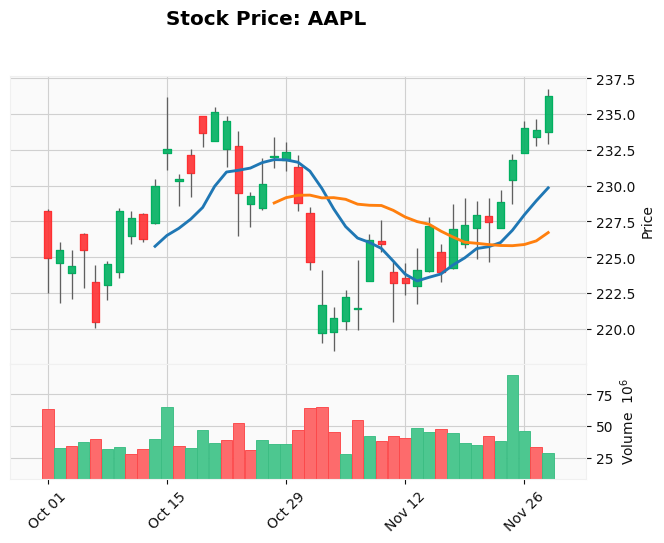

In [70]:
# 2. ตรวจสอบว่ามีข้อมูลหรือไม่ (ป้องกันกราฟว่างเปล่า)
if len(data) == 0:
    print("ไม่พบข้อมูลในช่วงเวลาที่กำหนด")
else:
    # 3. สร้างกราฟ
    print("กำลังสร้างกราฟ...")
    mpf.plot(data, 
             type='candle', 
             mav=(10, 20), 
             volume=True, 
             title=f'Stock Price: {symbol}',
             style='yahoo')

แปลงเป็น USD = Bat

/tmp/ipython-input-2175130423.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

กำลังดึงข้อมูล AAPL และอัตราแลกเปลี่ยน...



/tmp/ipython-input-2175130423.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download(currency, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


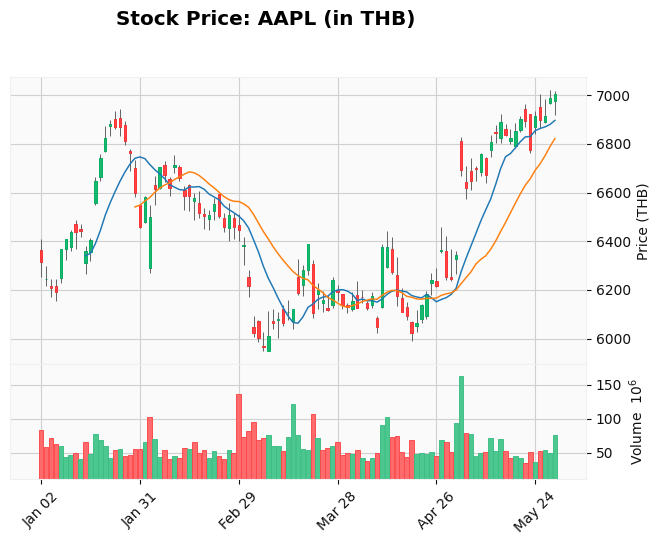

In [71]:
import yfinance as yf
import mplfinance as mpf
import pandas as pd

# 1. กำหนดค่า
symbol = 'AAPL'      # หุ้นที่ต้องการ (USD)
currency = 'THB=X'   # ค่าเงิน (USD to THB)
start_date = '2024-01-01'
end_date = '2024-06-01'

# 2. ดึงข้อมูลหุ้น และ ค่าเงิน
print(f"กำลังดึงข้อมูล {symbol} และอัตราแลกเปลี่ยน...")
stock_data = yf.download(symbol, start=start_date, end=end_date)
fx_data = yf.download(currency, start=start_date, end=end_date)

# --- แก้ปัญหา MultiIndex (เหมือนเดิม) ---
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.get_level_values(0)
if isinstance(fx_data.columns, pd.MultiIndex):
    fx_data.columns = fx_data.columns.get_level_values(0)

# 3. เตรียมข้อมูลสำหรับคำนวณ
# สร้าง DataFrame ใหม่ขึ้นมาเพื่อไม่ให้กระทบข้อมูลดิบ
thb_data = stock_data.copy()

# รวมตาราง (Merge) เพื่อให้วันที่ตรงกันเป๊ะๆ (เผื่อวันหยุดไม่ตรงกัน)
# ใช้ 'Close' ของค่าเงินมาเป็นตัวคูณ
combined = pd.merge(stock_data, fx_data['Close'], left_index=True, right_index=True, suffixes=('', '_FX'))
# ตอนนี้เราจะมี col ชื่อ 'Close_FX' ที่เป็นเรทเงินบาทอยู่ในตารางเดียวกันแล้ว

# 4. แปลงค่าเงิน (คูณ OHLC ด้วยเรทเงินบาท)
# Open, High, Low, Close ต้องคูณทั้งหมด
cols_to_convert = ['Open', 'High', 'Low', 'Close']

for col in cols_to_convert:
    # ราคาหุ้น (USD) * เรทเงิน (THB)
    thb_data[col] = combined[col] * combined['Close_FX']

# หมายเหตุ: Volume (ปริมาณซื้อขายหุ้น) ไม่ต้องคูณ เพราะจำนวนหุ้นเท่าเดิม

# 5. สร้างกราฟ
mpf.plot(thb_data, 
         type='candle', 
         mav=(10, 20), 
         volume=True, 
         title=f'Stock Price: {symbol} (in THB)', # เปลี่ยนหัวข้อกราฟ
         style='yahoo',
         ylabel='Price (THB)') # เปลี่ยนป้ายแกนข้างๆ เป็น THB